In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1" # per avere un trace degli errori CUDA

import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torch.nn import Linear, BatchNorm1d, LeakyReLU

In [2]:
X2 = np.load("graph_emb.npy")
Y2 = np.load("labels.npy")

In [3]:
X, Y = make_classification(
  n_samples=400, n_features=1, n_redundant=0,
  n_informative=1,  n_clusters_per_class=1, n_classes=2, 
    class_sep=0.3, hypercube=True, shift=0.9, scale=9
)

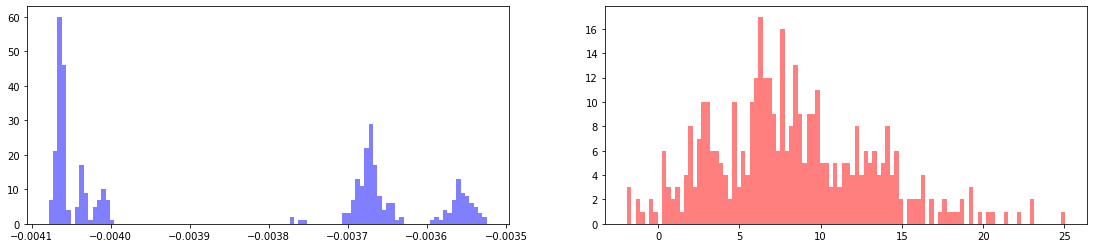

In [4]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(19,4))
bins1 = np.linspace(-1.5, 2.5, 100)
bins2 = np.linspace(-0.0045, -0.0035, 200)
ax1.hist(X2, bins=100, color='blue', alpha=0.5, label='graph_emb');
ax2.hist(X, bins=100, color='red', alpha=0.5,label='x')
plt.show()

In [5]:
#X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
X_train, X_test, Y_train, Y_test = train_test_split(X2, Y2, test_size=0.3, random_state=42)

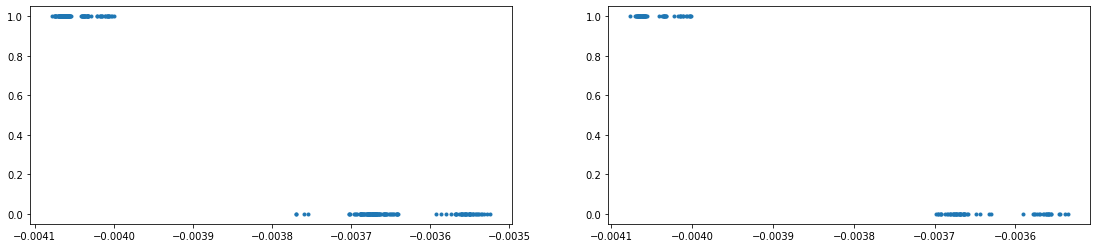

In [6]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(19,4))
ax1.plot(X_train, Y_train, '.')
ax2.plot(X_test, Y_test, '.')

In [7]:
class Data(Dataset):
    def __init__(self, X_train, y_train):
        self.X = torch.from_numpy(X_train.astype(np.float32)).to('cuda')
        self.y = torch.from_numpy(y_train).type(torch.float32).to('cuda')
        self.len = self.X.shape[0]

    def __getitem__(self, index):
        return self.X[index], self.y[index]
    def __len__(self):
        return self.len

In [8]:
traindata = Data(X_train, Y_train)
batch_size = 150
trainloader = DataLoader(traindata, batch_size=batch_size, shuffle=True, num_workers=0)
testdata = Data(X_test, Y_test)
testloader = DataLoader(testdata, batch_size=batch_size, shuffle=True, num_workers=0)

In [9]:
# number of features (len of X cols)
input_dim = 1
# number of hidden layers
hidden_layers = 2
# number of classes (unique of y)
output_dim = 1
class Network(nn.Module):
    def __init__(self, dropout=0.5):
        super(Network, self).__init__()
        self.linear1 = nn.Linear(input_dim, hidden_layers)
        self.drop = torch.nn.Dropout(p=dropout)
        self.linear2 = nn.Linear(hidden_layers, output_dim)
    def forward(self, x):
        #x = torch.sigmoid(self.linear1(x))
        x = self.linear1(x)
        x = self.drop(x)
        x = self.linear2(x)
        return x
    
class Network_wo_dropout(nn.Module):
    def __init__(self):
        super(Network_wo_dropout, self).__init__()
        self.linear1 = nn.Linear(input_dim, hidden_layers)
        self.linear2 = nn.Linear(hidden_layers, output_dim)
    def forward(self, x):
        #x = torch.sigmoid(self.linear1(x))
        x = self.linear1(x)
        x = self.linear2(x)
        return x

In [10]:
models = []
droput_ranges = np.arange(0,1.2,0.2)
for d in droput_ranges:
    model = Network()
    model.to('cuda')
    models.append(model)
    

In [10]:
model_wo_do = Network_wo_dropout()
model_wo_do.to('cuda')

Network_wo_dropout(
  (linear1): Linear(in_features=1, out_features=2, bias=True)
  (linear2): Linear(in_features=2, out_features=1, bias=True)
)

In [11]:
criterion = nn.BCEWithLogitsLoss()  # CrossEntropyLoss() #

In [12]:
def train(model, epochs):
    train_loss = []
    test_loss = []
    
    accuracy_list = []
    correct, total = 0, 0
    
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for i, data in enumerate(trainloader):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            running_loss += loss.item()
        train_loss.append(running_loss)
        
        # test loss and accuracy
        model.eval()
        running_loss = 0.0
        with torch.no_grad():
            for data in testloader:
                inputs, labels = data
                optimizer.zero_grad()
                outputs = model(inputs).squeeze()
                loss = criterion(outputs, labels)
                running_loss += loss.item()
                # calcola l'accuracy
                predicted = outputs > 0.5
                total += labels.size(0)
                correct += (predicted.squeeze() == labels).sum().item()
                
        test_loss.append(running_loss)
        accuracy_list.append(correct / total)
        
    return train_loss, test_loss, accuracy_list

In [14]:
train_losses = []
test_losses = []
accuracys = []
epochs = 2000

In [13]:
for m in models:
    train_loss, test_loss, accuracy_list = train(m, epochs)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    accuracys.append(accuracy_list)
    

In [15]:
train_loss, test_loss, accuracy_list = train(model_wo_do, epochs)
train_losses.append(train_loss)
test_losses.append(test_loss)
accuracys.append(accuracy_list)

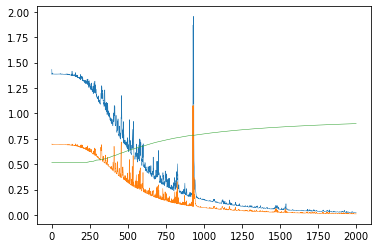

In [25]:
plt.plot(train_loss, alpha=1, markersize=0.5, linewidth=0.5)#, label=f"No_d", color='black')
plt.plot(test_loss, alpha=1, markersize=0.5, linewidth=0.5)#, label=f"No_d", color='black')
plt.plot(accuracy_list, alpha=1, markersize=0.5, linewidth=0.5)#, label=f"No_d", color='black')

In [ ]:
def plot_losses(losses):
    plt.figure(figsize=(18, 9))
    for i, d in enumerate(droput_ranges):
        plt.plot(losses[i], alpha=0.8, markersize=0.5, linewidth=0.5, label=f"d {round(d,1)}", )
        #plt.title(f"Dropout rate: {d}")

    plt.plot(losses[-1], alpha=1, markersize=0.5, linewidth=0.5, label=f"No_d", color='black')
    plt.ylim(0.0, 1.5)
    plt.legend(loc="lower left")
    plt.show()
    
plot_losses(train_losses)
plot_losses(test_losses)
plot_losses(accuracys)

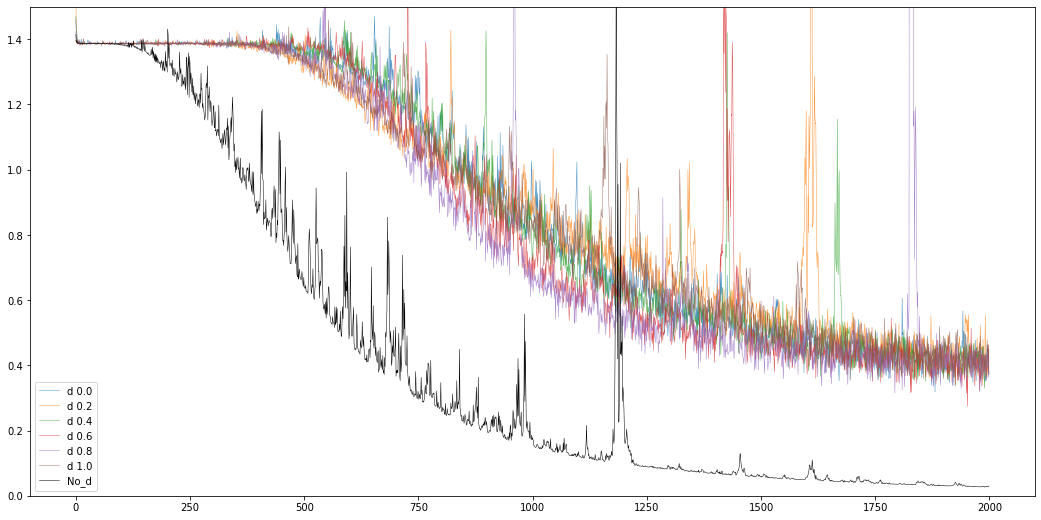

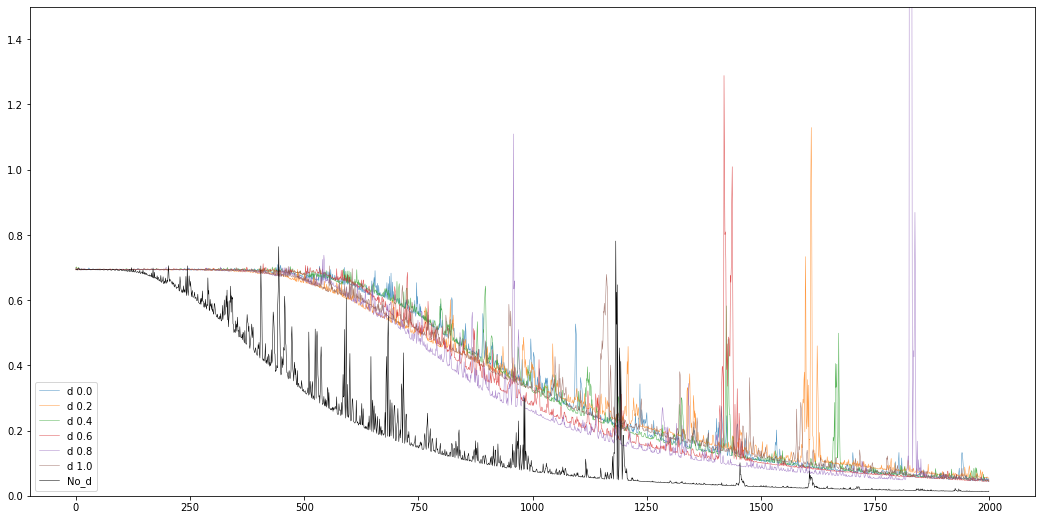

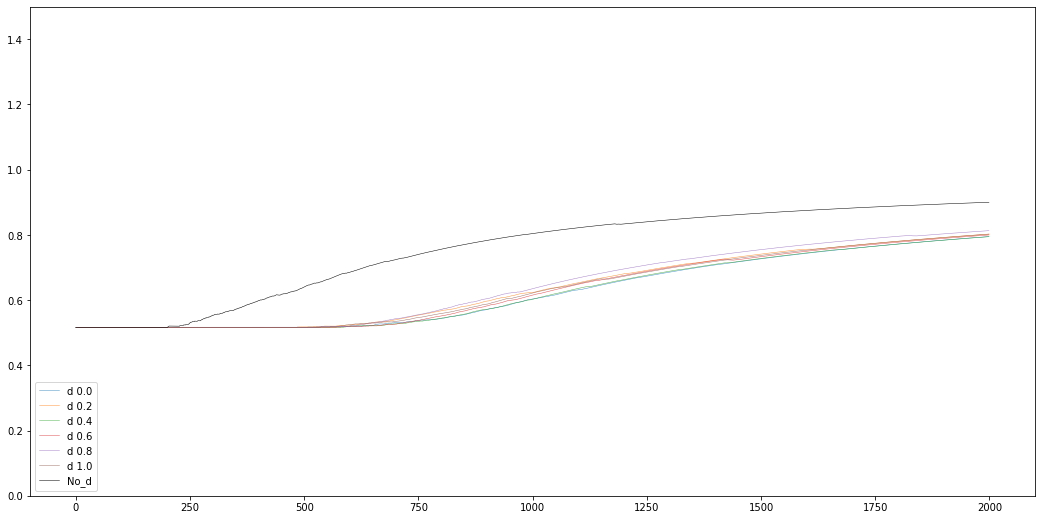

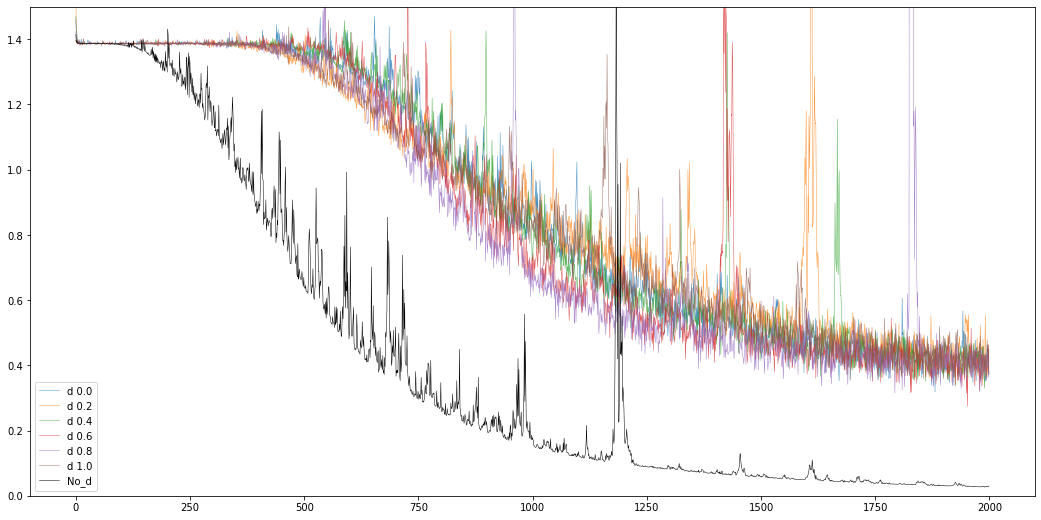

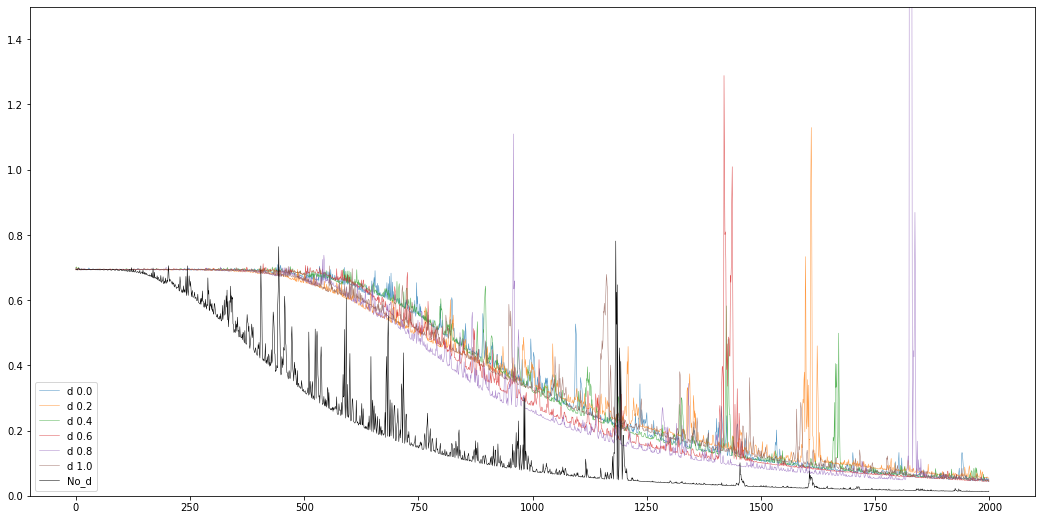

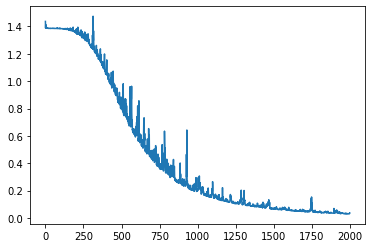

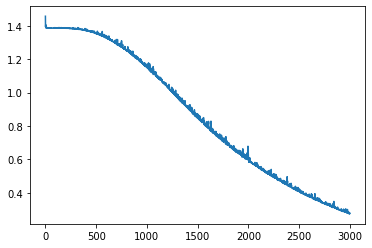

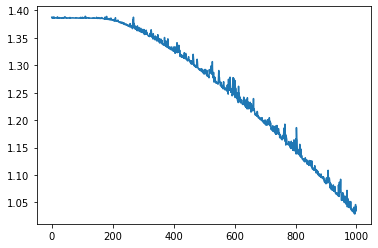

Accuracy of the network on the 120 test data: 1
